In [378]:
import numpy as np
import pandas as pd


In [379]:
df = pd.read_csv('loan_data.csv')

In [380]:
print("Dataset shape:", df.shape)
df.head()

Dataset shape: (614, 13)


,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


In [381]:
print("Missing values per column:")
print(df.isnull().sum())

Missing values per column:
Loan_ID               0
Gender               13
Married               3
Dependents           15
Education             0
Self_Employed        32
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount           22
Loan_Amount_Term     14
Credit_History       50
Property_Area         0
Loan_Status           0
dtype: int64


In [382]:
num_cols = ['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount', 'Loan_Amount_Term']
df[num_cols] = df[num_cols].fillna(df[num_cols].median())

cat_cols = ['Gender', 'Married', 'Dependents', 'Self_Employed', 'Credit_History']
df[cat_cols] = df[cat_cols].fillna(df[cat_cols].mode().iloc[0])


In [383]:
df['TotalIncome'] = df['ApplicantIncome'] + df['CoapplicantIncome']
df['LoanAmountToIncome'] = df['LoanAmount'] / df['TotalIncome']
df['LoanAmountToTerm'] = df['LoanAmount'] / df['Loan_Amount_Term']

In [384]:
df['Credit_History'] = df['Credit_History'].astype('object')

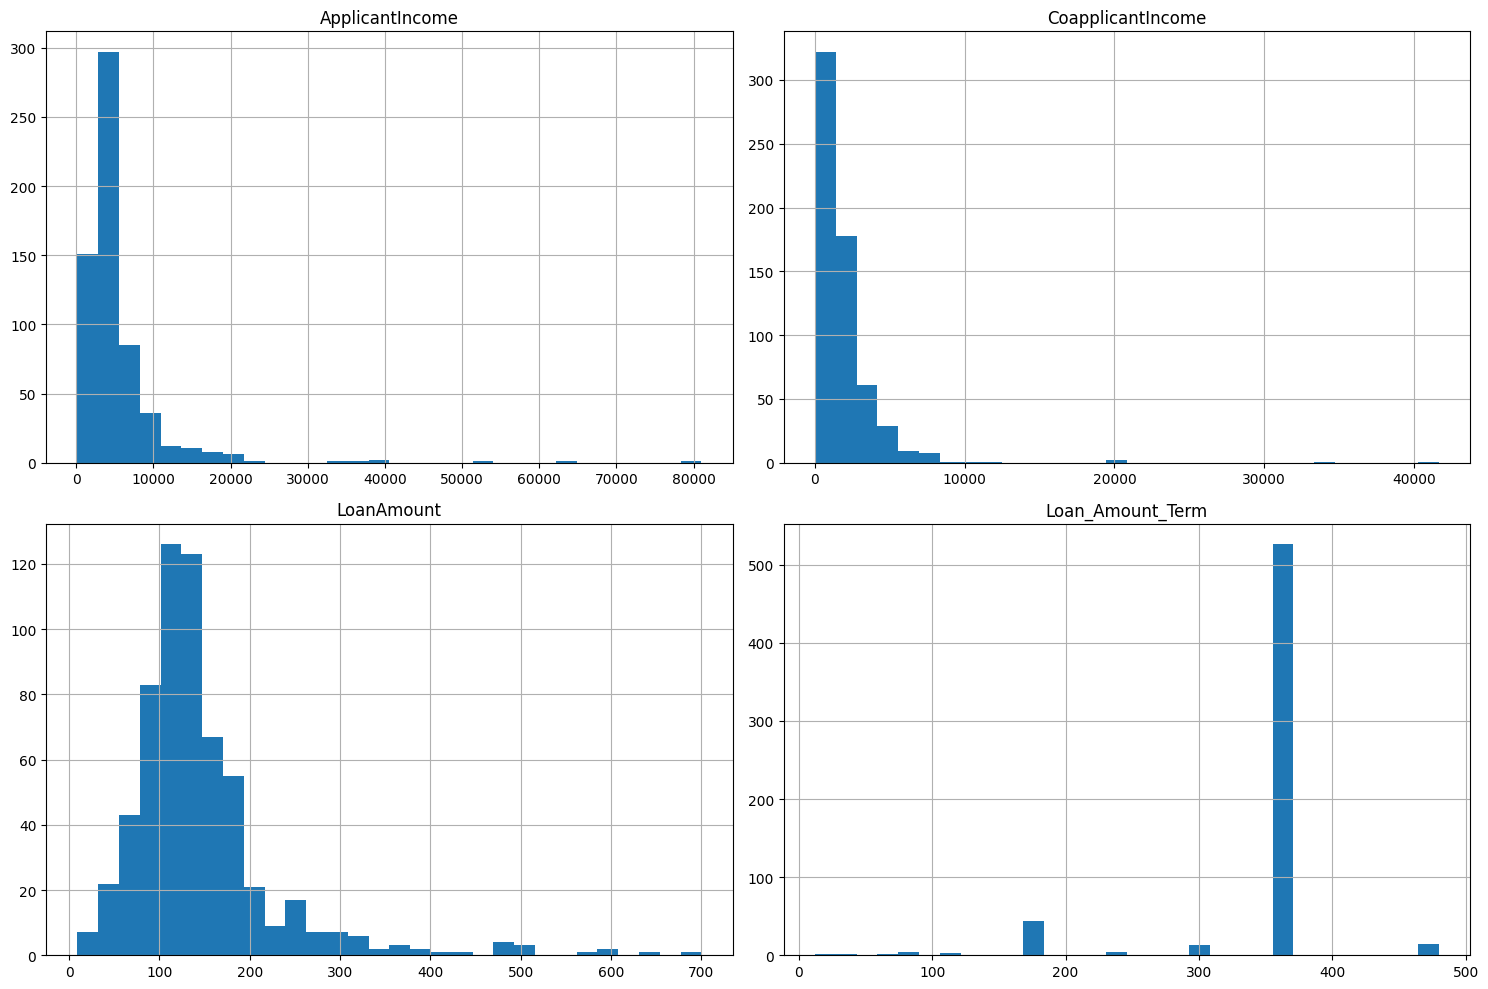

In [385]:
import matplotlib.pyplot as plt
import seaborn as sns
df[num_cols].hist(bins=30, figsize=(15, 10))
plt.tight_layout()
plt.show()

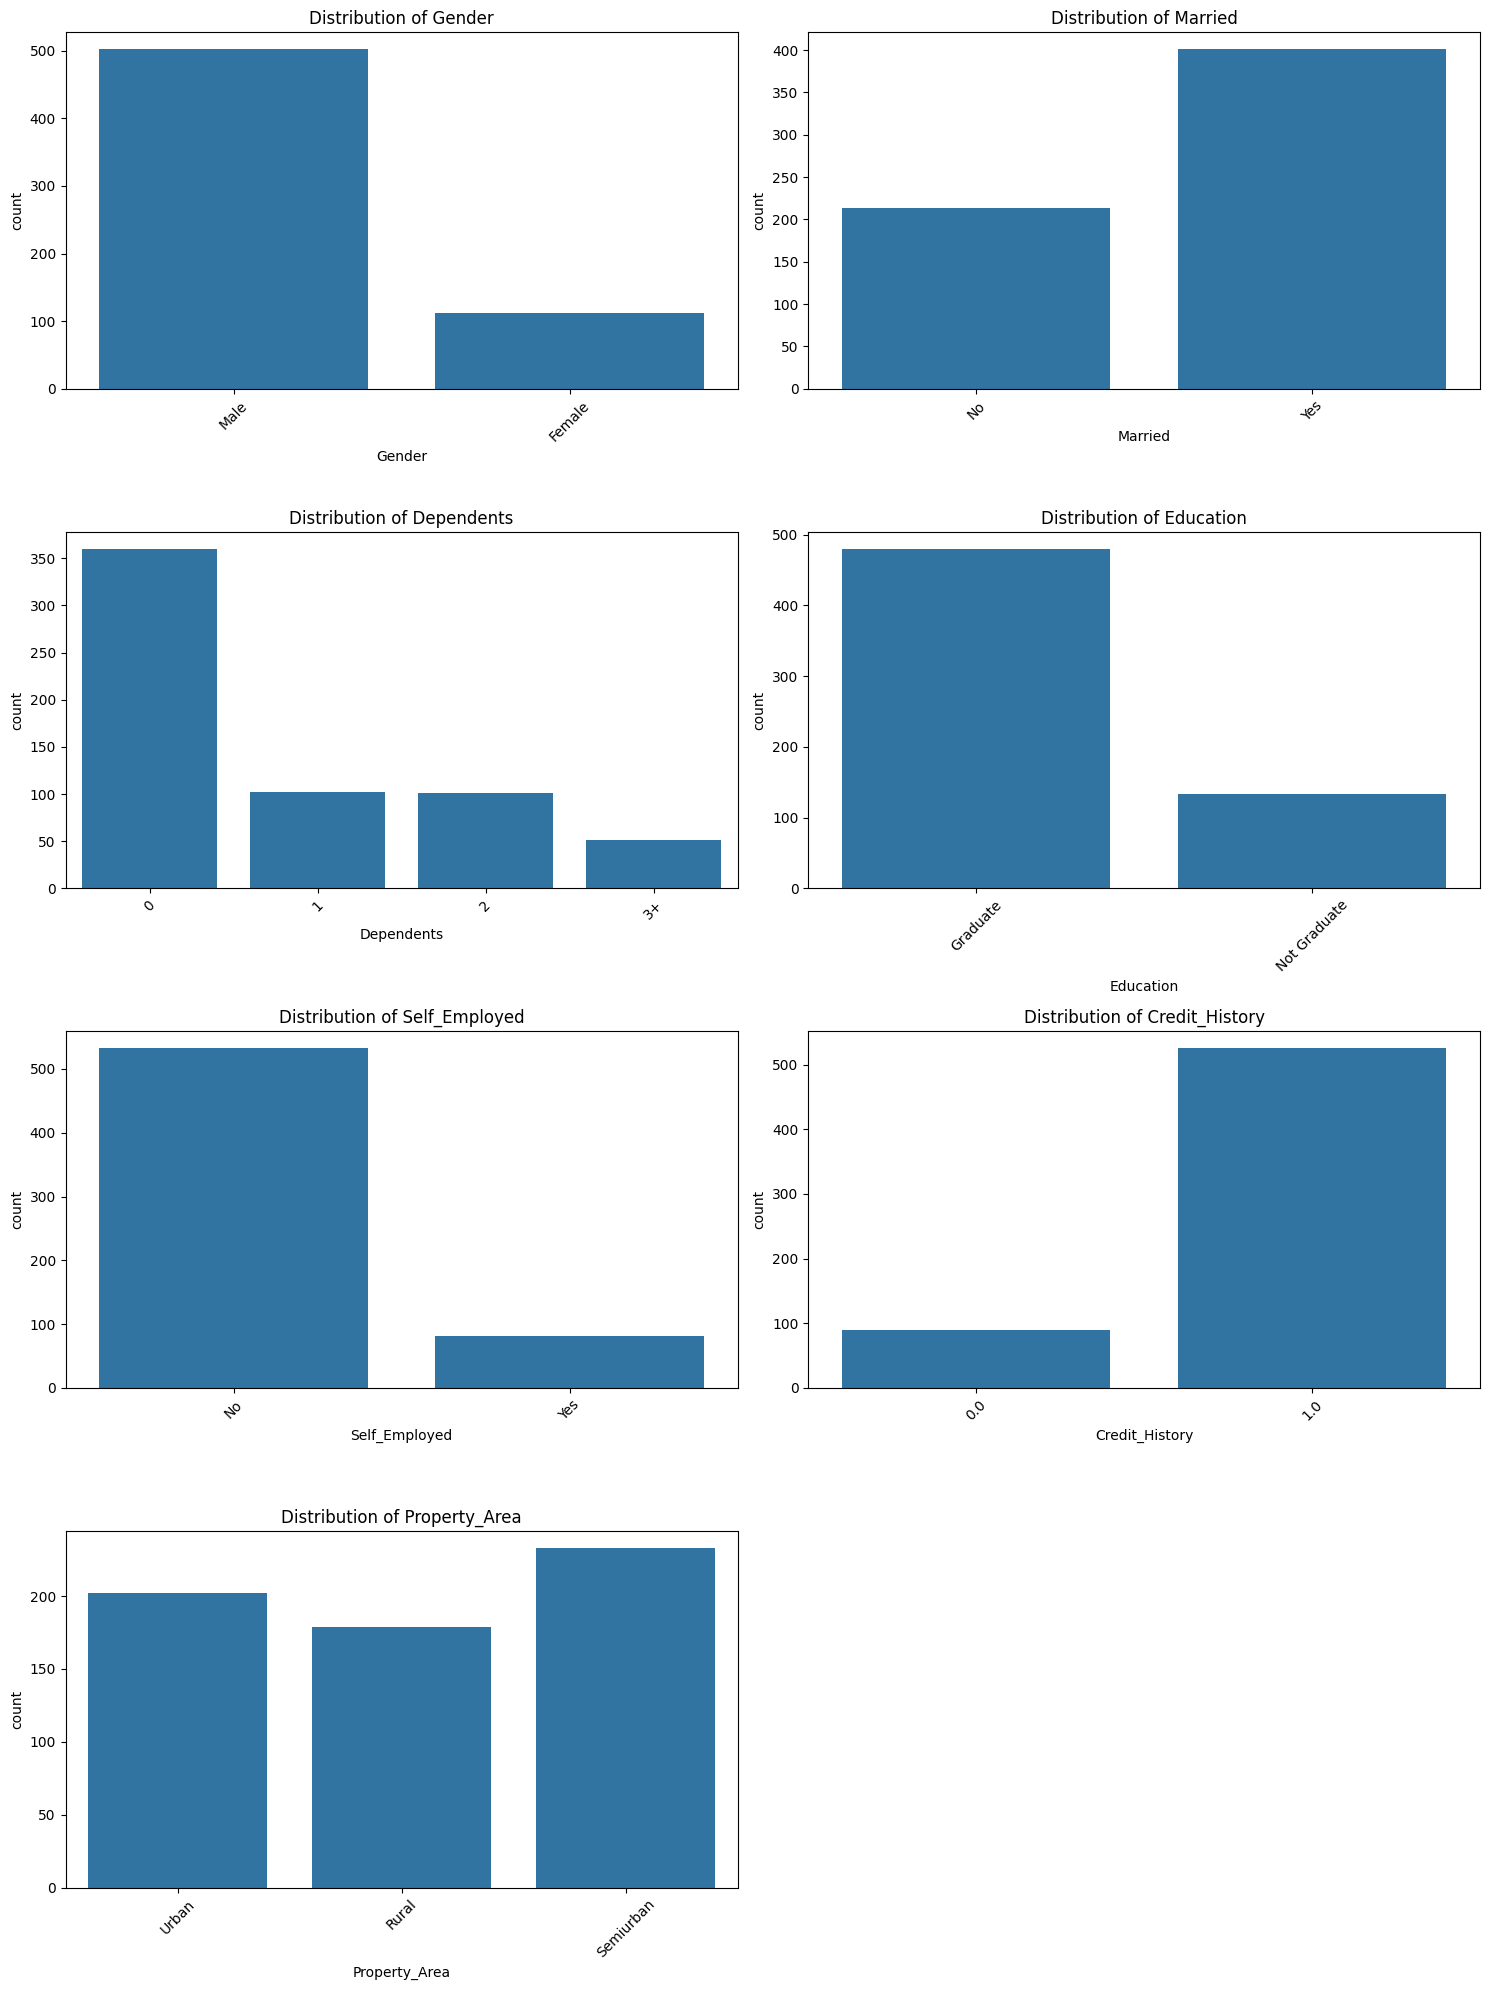

In [386]:
cat_features = ['Gender', 'Married', 'Dependents', 'Education', 'Self_Employed', 'Credit_History', 'Property_Area']
plt.figure(figsize=(15, 20))
for i, feature in enumerate(cat_features, 1):
    plt.subplot(4, 2, i)
    sns.countplot(data=df, x=feature)
    plt.title(f'Distribution of {feature}')
    plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [387]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split

In [388]:
X = df.drop(columns=['Loan_ID', 'Loan_Status']) 
y = df['Loan_Status'].map({'Y': 1, 'N': 0})  
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [389]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

In [390]:
numerical_features = ['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount', 
                      'Loan_Amount_Term', 'TotalIncome', 'LoanAmountToIncome', 'LoanAmountToTerm']
categorical_features = ['Gender', 'Married', 'Dependents', 'Education', 
                        'Self_Employed', 'Credit_History', 'Property_Area']

numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)])

In [391]:
models = {
    'RandomForest': RandomForestClassifier(random_state=42, class_weight='balanced'),
    'LogisticRegression': LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42)
}

In [392]:
param_grids = {
    'RandomForest': {
        'classifier__n_estimators': [50, 100, 200],
        'classifier__max_depth': [None, 10, 20]
    },
    'LogisticRegression': {
        'classifier__C': [0.01, 0.1, 1.0, 10.0]
    }
}

In [393]:
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score


In [394]:
scoring = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']
pipelines = {}


In [395]:
from sklearn.model_selection import cross_validate, GridSearchCV
from sklearn.exceptions import NotFittedError


In [ ]:
for name, model in models.items():
    pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('classifier', model)])
    
    grid_search = GridSearchCV(pipeline, param_grids[name], cv=5, scoring='f1', n_jobs=-1)
    grid_search.fit(X_train, y_train)
    
    pipelines[name] = grid_search.best_estimator_
    
    cv_results = cross_validate(grid_search.best_estimator_, X_train, y_train, cv=5, scoring=scoring)
    mean_f1 = np.mean(cv_results['test_f1'])
    
    print(f"{name} Model (Tuned) Cross-Validation Results:")
    print(f"  Best Parameters: {grid_search.best_params_}")
    print(f"  Accuracy: {np.mean(cv_results['test_accuracy']):.4f}")
    print(f"  Precision: {np.mean(cv_results['test_precision']):.4f}")
    print(f"  Recall: {np.mean(cv_results['test_recall']):.4f}")
    print(f"  F1-Score: {mean_f1:.4f}")
    print(f"  AUC-ROC: {np.mean(cv_results['test_roc_auc']):.4f}")
    print("-" * 50)

RandomForest Model (Tuned) Cross-Validation Results:
  Best Parameters: {'classifier__max_depth': None, 'classifier__n_estimators': 200}
  Accuracy: 0.7801
  Precision: 0.7788
  Recall: 0.9496
  F1-Score: 0.8557
  AUC-ROC: 0.7621
--------------------------------------------------
LogisticRegression Model (Tuned) Cross-Validation Results:
  Best Parameters: {'classifier__C': 0.01}
  Accuracy: 0.7434
  Precision: 0.7894
  Recall: 0.8546
  F1-Score: 0.8206
  AUC-ROC: 0.7226
--------------------------------------------------


In [397]:
best_model_name = 'RandomForest'
best_pipeline = pipelines['RandomForest']
print(f"Chosen Model: {best_model_name} (Better Accuracy and F1-Score)")


Chosen Model: RandomForest (Better Accuracy and F1-Score)


In [398]:
best_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['ApplicantIncome',
                                                   'CoapplicantIncome',
                                                   'LoanAmount',
                                                   'Loan_Amount_Term',
                                                   'TotalIncome',
                                                   'LoanAmountToIncome',
                                                   'LoanAmountToTerm']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Gender', 'Married',
                                                   'Dependents', 'Education',
                                                   'Self_Employed',
                                                   'Credit_History',
                                                   'Property_Area'])])),
                ('classifier',
                 RandomForestClassifier(class_weight='balanced',
                                        n_estimators=200, random_state=42))])

In [399]:
try:
    y_pred = best_pipeline.predict(X_test)
    y_pred_proba = best_pipeline.predict_proba(X_test)[:, 1]
except NotFittedError:
    print("Error: Pipeline not fitted. Re-fitting now...")
    best_pipeline.fit(X_train, y_train)
    y_pred = best_pipeline.predict(X_test)
    y_pred_proba = best_pipeline.predict_proba(X_test)[:, 1]

print(f"\nTest Set Evaluation for {best_model_name}:")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(f"Classification Report:\n{classification_report(y_test, y_pred)}")
print(f"AUC-ROC: {roc_auc_score(y_test, y_pred_proba):.4f}")


Test Set Evaluation for RandomForest:
Accuracy: 0.8537
Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.63      0.73        38
           1       0.85      0.95      0.90        85

    accuracy                           0.85       123
   macro avg       0.85      0.79      0.81       123
weighted avg       0.85      0.85      0.85       123

AUC-ROC: 0.8502


In [400]:
import joblib

In [401]:
joblib.dump(pipeline, 'best_loan_approval_model.joblib')
print("Best trained model saved to 'best_loan_approval_model.joblib'")

Best trained model saved to 'best_loan_approval_model.joblib'


In [402]:
model = joblib.load('best_loan_approval_model.joblib')

In [ ]:
try:
    model.predict(X_train[:1]) 
    print("Loaded model is already fitted.")
except NotFittedError:
    print("Loaded model not fitted. Re-fitting now...")
    model.fit(X_train, y_train)

Loaded model not fitted. Re-fitting now...


In [404]:
dummy_data = pd.read_csv('dummy_loan_applicants.csv')

In [405]:
dummy_data['TotalIncome'] = dummy_data['ApplicantIncome'] + dummy_data['CoapplicantIncome']
dummy_data['LoanAmountToIncome'] = dummy_data['LoanAmount'] / dummy_data['TotalIncome']
dummy_data['LoanAmountToTerm'] = dummy_data['LoanAmount'] / dummy_data['Loan_Amount_Term']

In [406]:
predictions = model.predict(dummy_data)
predicted_probabilities = model.predict_proba(dummy_data)[:, 1]

In [407]:
dummy_data['Loan_Status_Predicted'] = predictions
dummy_data['Approval_Probability'] = predicted_probabilities

In [408]:
dummy_data['Loan_Status_Predicted'] = dummy_data['Loan_Status_Predicted'].map({1: 'Approved', 0: 'Rejected'})


In [409]:
print(dummy_data[['Loan_Status_Predicted', 'Approval_Probability']])

   Loan_Status_Predicted  Approval_Probability
0               Rejected              0.066396
1               Rejected              0.359081
2               Rejected              0.022618
3               Approved              0.508215
4               Rejected              0.044650
5               Approved              0.804795
6               Approved              0.518739
7               Rejected              0.399522
8               Rejected              0.016333
9               Approved              0.749466
10              Rejected              0.474708
11              Approved              0.611920
12              Rejected              0.027380
13              Approved              0.585197
14              Approved              0.845415
15              Approved              0.637063
16              Rejected              0.459391
17              Rejected              0.062464
18              Rejected              0.019608
19              Rejected              0.015491


In [410]:
dummy_data.to_csv('predicted_loan_applicants.csv', index=False)

print("\nPredictions saved in 'predicted_loan_applicants.csv'")



Predictions saved in 'predicted_loan_applicants.csv'
